<a href="https://colab.research.google.com/github/achyutpratap6/Medical-Image-classification-using-Deep-Learning/blob/main/CAPSTONE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [4]:
!nvidia-smi

Mon Dec 11 02:57:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow

In [6]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imutils import paths
import argparse
import random
import pickle
import cv2
import os

In [8]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [9]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

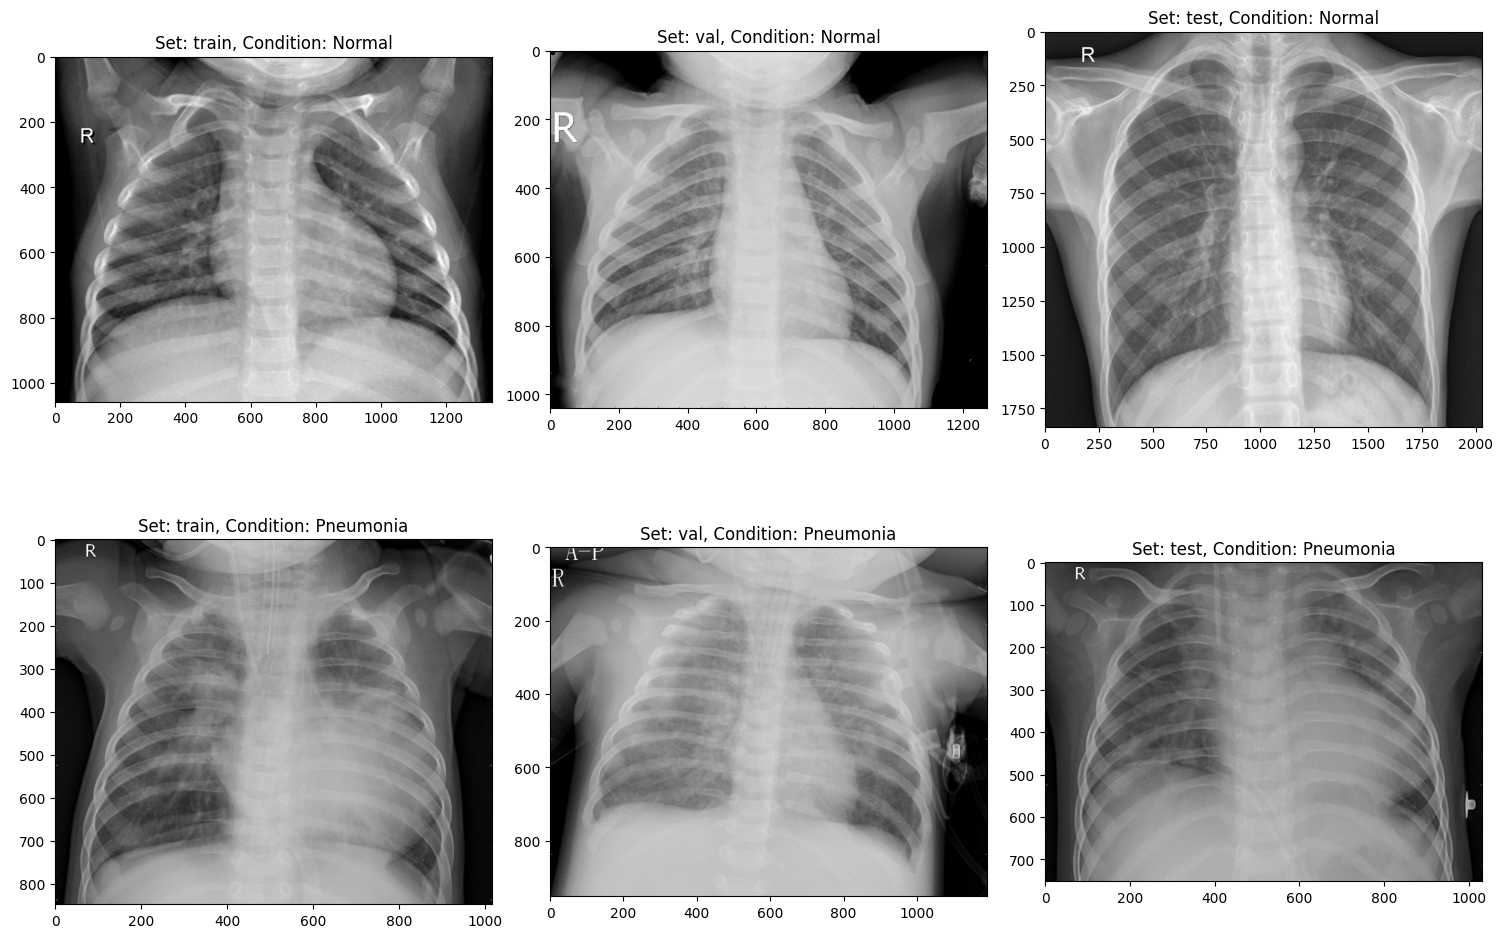

In [10]:
# Image Size
IMAGE_SIZE = (150,150)
# Path of data folder
path = '/content/grive/MyDrive/DAB422/Chest_XRay/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path + _set

    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))

    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [11]:
def process_data(img_dims, batch_size):

    # Data generation objects
    train_datagen = image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )

    test_val_datagen = ImageDataGenerator(
                                    rescale=1./255
                                )

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
                    directory= path + 'train',
                    target_size=(img_dims, img_dims),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'test',
                    target_size=(img_dims, img_dims),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

    val_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'val',
                    target_size=(img_dims, img_dims),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [12]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
## CNN Architecture
def model_fns(input1, hidden1, output1):
  inputs = Input(shape=(img_dims, img_dims, 3))

  # First conv block
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(inputs)
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # FC layer
  x = Flatten()(x)
  x = Dense(units=512, activation=hidden1)(x)
  x = Dropout(rate=0.7)(x)
  x = Dense(units=128, activation=hidden1)(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=64, activation=hidden1)(x)
  x = Dropout(rate=0.3)(x)

  # Output layer
  output = Dense(units=1, activation=output1)(x)

  # Creating model and compiling
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Callbacks
  checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

  hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

In [ ]:
model_fns('relu', 'relu', 'tanh')

Epoch 1/10
163/163 [==============================] - 1400s 9s/step - loss: 1.3879 - accuracy: 0.7258 - val_loss: 0.6050 - val_accuracy: 0.7582 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 93s 574ms/step - loss: 0.3679 - accuracy: 0.8510 - val_loss: 0.9683 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 90s 551ms/step - loss: 0.3536 - accuracy: 0.8715 - val_loss: 0.7022 - val_accuracy: 0.8289 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8969
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 88s 542ms/step - loss: 0.3139 - accuracy: 0.8969 - val_loss: 0.7035 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 88s 541ms/step - loss: 0.2696 - accuracy: 0.9030 - val_loss: 0.4990 - val_accuracy: 0.8273 - lr: 3.0000e-04
Epoch 6/10
163/163 [==========================

In [ ]:
model_fns('relu', 'tanh', 'tanh')

Epoch 1/10
163/163 [==============================] - 93s 559ms/step - loss: 1.5927 - accuracy: 0.6756 - val_loss: 1.6786 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 94s 576ms/step - loss: 1.1448 - accuracy: 0.6921 - val_loss: 1.0246 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.9665 - accuracy: 0.6998
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 92s 566ms/step - loss: 0.9665 - accuracy: 0.6998 - val_loss: 1.2868 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 90s 551ms/step - loss: 0.9427 - accuracy: 0.7023 - val_loss: 1.0708 - val_accuracy: 0.6234 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.7067
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('relu', 'sigmoid', 'tanh')

Epoch 1/10
163/163 [==============================] - 95s 563ms/step - loss: 0.7513 - accuracy: 0.7086 - val_loss: 0.7809 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 95s 584ms/step - loss: 0.6221 - accuracy: 0.7199 - val_loss: 0.7284 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.7287
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 91s 554ms/step - loss: 0.6035 - accuracy: 0.7287 - val_loss: 0.6834 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 91s 558ms/step - loss: 0.5936 - accuracy: 0.7308 - val_loss: 0.7056 - val_accuracy: 0.6201 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7333
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('relu', 'softmax', 'tanh')

Epoch 1/10
163/163 [==============================] - 97s 579ms/step - loss: 1.4260 - accuracy: 0.2571 - val_loss: 0.9486 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 548ms/step - loss: 0.9363 - accuracy: 0.2571 - val_loss: 0.7774 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.7699 - accuracy: 0.2757
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 100s 614ms/step - loss: 0.7699 - accuracy: 0.2757 - val_loss: 0.7051 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 90s 550ms/step - loss: 0.7071 - accuracy: 0.4210 - val_loss: 0.6922 - val_accuracy: 0.6299 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5734
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=====================

In [ ]:
model_fns('tanh', 'relu', 'tanh')

Epoch 1/10
163/163 [==============================] - 108s 647ms/step - loss: 10.1392 - accuracy: 0.3391 - val_loss: 9.6152 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 107s 659ms/step - loss: 10.4514 - accuracy: 0.3217 - val_loss: 5.7435 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 9.9436 - accuracy: 0.3545
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 101s 618ms/step - loss: 9.9436 - accuracy: 0.3545 - val_loss: 9.5899 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 100s 612ms/step - loss: 11.1401 - accuracy: 0.2776 - val_loss: 9.6660 - val_accuracy: 0.3734 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 103s 634ms/step - loss: 11.0639 - accuracy: 0.2824 - val_loss: 9.7167 - val_accuracy: 0.3701 - lr: 3.0000e-04
Epoch 6/10
163/163 [============

In [ ]:
model_fns('tanh', 'tanh', 'tanh')

Epoch 1/10
163/163 [==============================] - 98s 592ms/step - loss: 2.1420 - accuracy: 0.6543 - val_loss: 1.3002 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 105s 648ms/step - loss: 1.5257 - accuracy: 0.6848 - val_loss: 0.8980 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 104s 638ms/step - loss: 1.4407 - accuracy: 0.6890 - val_loss: 1.5115 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 103s 630ms/step - loss: 1.3938 - accuracy: 0.7023 - val_loss: 1.3094 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.6959
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 98s 602ms/step - loss: 1.3604 - accuracy: 0.6959 - val_loss: 1.1222 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/10
163/163 [==========================

In [ ]:
model_fns('tanh', 'sigmoid', 'tanh')

Epoch 1/10
163/163 [==============================] - 97s 581ms/step - loss: 1.2428 - accuracy: 0.6875 - val_loss: 0.9738 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 99s 609ms/step - loss: 0.6655 - accuracy: 0.7163 - val_loss: 0.7436 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.7176
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 105s 643ms/step - loss: 0.6163 - accuracy: 0.7176 - val_loss: 0.7055 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 99s 606ms/step - loss: 0.5983 - accuracy: 0.7280 - val_loss: 0.7137 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7274
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=====================

In [ ]:
model_fns('tanh', 'softmax', 'tanh')

Epoch 1/10
163/163 [==============================] - 90s 540ms/step - loss: 1.9425 - accuracy: 0.2571 - val_loss: 1.3073 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 545ms/step - loss: 1.3598 - accuracy: 0.2571 - val_loss: 1.0526 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.2571
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 88s 540ms/step - loss: 1.1079 - accuracy: 0.2571 - val_loss: 0.9046 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 88s 541ms/step - loss: 0.9922 - accuracy: 0.2571 - val_loss: 0.8681 - val_accuracy: 0.3766 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.9446 - accuracy: 0.2571
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('sigmoid', 'relu', 'tanh')

Epoch 1/10
163/163 [==============================] - 110s 648ms/step - loss: 10.0619 - accuracy: 0.3436 - val_loss: 9.6913 - val_accuracy: 0.3717 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 546ms/step - loss: 10.9109 - accuracy: 0.2920 - val_loss: 9.5899 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 11.3764 - accuracy: 0.2625
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 98s 603ms/step - loss: 11.3764 - accuracy: 0.2625 - val_loss: 9.6406 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 95s 580ms/step - loss: 11.4001 - accuracy: 0.2607 - val_loss: 9.6152 - val_accuracy: 0.3766 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 91s 556ms/step - loss: 11.3939 - accuracy: 0.2613 - val_loss: 9.7167 - val_accuracy: 0.3701 - lr: 3.0000e-04
Epoch 6/10
163/163 [==============

In [ ]:
model_fns('sigmoid', 'tanh', 'tanh')

Epoch 1/10
163/163 [==============================] - 1806s 11s/step - loss: 1.6452 - accuracy: 0.6748 - val_loss: 1.5001 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 95s 581ms/step - loss: 1.1461 - accuracy: 0.7084 - val_loss: 1.1870 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 1.1431 - accuracy: 0.7023
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 89s 547ms/step - loss: 1.1431 - accuracy: 0.7023 - val_loss: 1.0103 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 89s 547ms/step - loss: 1.1209 - accuracy: 0.6925 - val_loss: 1.1115 - val_accuracy: 0.6266 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.7055
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('sigmoid', 'sigmoid', 'tanh')

Epoch 1/10
163/163 [==============================] - 93s 550ms/step - loss: 0.7363 - accuracy: 0.7057 - val_loss: 0.7501 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 94s 580ms/step - loss: 0.6201 - accuracy: 0.7235 - val_loss: 0.6846 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7345
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 93s 568ms/step - loss: 0.5966 - accuracy: 0.7345 - val_loss: 0.6947 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 93s 570ms/step - loss: 0.5884 - accuracy: 0.7373 - val_loss: 0.6944 - val_accuracy: 0.6201 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.7377
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('sigmoid', 'softmax', 'tanh')

Epoch 1/10
163/163 [==============================] - 92s 555ms/step - loss: 8.4670 - accuracy: 0.2571 - val_loss: 1.7187 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 84s 516ms/step - loss: 1.8255 - accuracy: 0.2571 - val_loss: 1.4004 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 1.5280 - accuracy: 0.2571
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 84s 513ms/step - loss: 1.5280 - accuracy: 0.2571 - val_loss: 1.2172 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 85s 522ms/step - loss: 1.3917 - accuracy: 0.2571 - val_loss: 1.1755 - val_accuracy: 0.3734 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.2571
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('softmax', 'relu', 'tanh')

Epoch 1/10
163/163 [==============================] - 85s 511ms/step - loss: 3.9241 - accuracy: 0.7393 - val_loss: 5.7435 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 84s 518ms/step - loss: 3.9205 - accuracy: 0.7429 - val_loss: 5.7435 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 91s 555ms/step - loss: 3.9205 - accuracy: 0.7429 - val_loss: 5.7686 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 86s 525ms/step - loss: 3.9205 - accuracy: 0.7429 - val_loss: 5.7435 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 3.9176 - accuracy: 0.7431
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 85s 521ms/step - loss: 3.9176 - accuracy: 0.7431 - val_loss: 5.6432 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 6/10
163/163 [=============================

In [ ]:
model_fns('softmax', 'tanh', 'tanh')

Epoch 1/10
163/163 [==============================] - 1802s 11s/step - loss: 1.4389 - accuracy: 0.6706 - val_loss: 1.6748 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 399s 2s/step - loss: 1.1208 - accuracy: 0.7040 - val_loss: 1.1718 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.7090
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 393s 2s/step - loss: 1.0020 - accuracy: 0.7090 - val_loss: 1.0581 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 398s 2s/step - loss: 0.9938 - accuracy: 0.7189 - val_loss: 1.0463 - val_accuracy: 0.6168 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.9962 - accuracy: 0.7049
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [============================

In [ ]:
model_fns('softmax', 'sigmoid', 'tanh')

Epoch 1/10
163/163 [==============================] - 393s 2s/step - loss: 1.4376 - accuracy: 0.6655 - val_loss: 0.7593 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 405s 2s/step - loss: 0.6278 - accuracy: 0.7189 - val_loss: 0.6852 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7239
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 407s 2s/step - loss: 0.5975 - accuracy: 0.7239 - val_loss: 0.6991 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 397s 2s/step - loss: 0.5939 - accuracy: 0.7337 - val_loss: 0.6963 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.7364
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==============================

In [ ]:
model_fns('softmax', 'softmax', 'tanh')

Epoch 1/10
163/163 [==============================] - 1703s 10s/step - loss: 7.0319 - accuracy: 0.2571 - val_loss: 1.5402 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 544ms/step - loss: 1.6437 - accuracy: 0.2571 - val_loss: 1.2729 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 1.3843 - accuracy: 0.2571
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 91s 556ms/step - loss: 1.3843 - accuracy: 0.2571 - val_loss: 1.1084 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 91s 556ms/step - loss: 1.2656 - accuracy: 0.2571 - val_loss: 1.0759 - val_accuracy: 0.3750 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 1.2144 - accuracy: 0.2571
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('relu', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 90s 533ms/step - loss: 0.8681 - accuracy: 0.7467 - val_loss: 0.8323 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 87s 534ms/step - loss: 0.3446 - accuracy: 0.8612 - val_loss: 1.0622 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 90s 554ms/step - loss: 0.2911 - accuracy: 0.8850 - val_loss: 0.8239 - val_accuracy: 0.8010 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.8896
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 88s 541ms/step - loss: 0.2807 - accuracy: 0.8896 - val_loss: 0.9578 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 89s 544ms/step - loss: 0.2372 - accuracy: 0.9120 - val_loss: 0.7960 - val_accuracy: 0.8026 - lr: 3.0000e-04
Epoch 6/10
163/163 [=========================

In [ ]:
model_fns('relu', 'tanh', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 92s 553ms/step - loss: 0.6334 - accuracy: 0.7005 - val_loss: 0.7511 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 90s 553ms/step - loss: 0.6086 - accuracy: 0.7278 - val_loss: 0.7591 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 91s 559ms/step - loss: 0.6071 - accuracy: 0.7337 - val_loss: 0.7157 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7333
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 91s 559ms/step - loss: 0.5981 - accuracy: 0.7333 - val_loss: 0.7165 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 91s 560ms/step - loss: 0.5830 - accuracy: 0.7385 - val_loss: 0.7346 - val_accuracy: 0.6299 - lr: 3.0000e-04
Epoch 6/10
163/163 [=========================

In [ ]:
model_fns('relu', 'sigmoid', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 88s 530ms/step - loss: 0.6038 - accuracy: 0.7220 - val_loss: 0.7225 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 93s 568ms/step - loss: 0.5815 - accuracy: 0.7402 - val_loss: 0.7321 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 91s 558ms/step - loss: 0.5743 - accuracy: 0.7427 - val_loss: 0.7031 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.7429
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 89s 546ms/step - loss: 0.5821 - accuracy: 0.7429 - val_loss: 0.6920 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 93s 571ms/step - loss: 0.5759 - accuracy: 0.7429 - val_loss: 0.6918 - val_accuracy: 0.6283 - lr: 3.0000e-04
Epoch 6/10
163/163 [=========================

In [ ]:
model_fns('relu', 'softmax', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 107s 623ms/step - loss: 0.6534 - accuracy: 0.7418 - val_loss: 0.6656 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 544ms/step - loss: 0.6069 - accuracy: 0.7429 - val_loss: 0.6633 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 90s 548ms/step - loss: 0.5847 - accuracy: 0.7429 - val_loss: 0.6718 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 86s 529ms/step - loss: 0.5761 - accuracy: 0.7429 - val_loss: 0.6760 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 91s 556ms/step - loss: 0.5719 - accuracy: 0.7429 - val_loss: 0.6795 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 86s 531ms/step - loss: 0.5710 - accuracy: 0.7429 - val_loss: 0.6938 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 7/10
163/163 [==============================]

In [ ]:
model_fns('tanh', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 90s 538ms/step - loss: 1.2521 - accuracy: 0.6630 - val_loss: 0.5854 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 88s 539ms/step - loss: 0.4898 - accuracy: 0.7728 - val_loss: 0.3922 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8468
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 86s 528ms/step - loss: 0.3503 - accuracy: 0.8468 - val_loss: 0.3689 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 88s 538ms/step - loss: 0.2554 - accuracy: 0.8934 - val_loss: 0.3084 - val_accuracy: 0.8766 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.8990
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('tanh', 'tanh', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 89s 533ms/step - loss: 0.6463 - accuracy: 0.6975 - val_loss: 0.7498 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 87s 534ms/step - loss: 0.6170 - accuracy: 0.7209 - val_loss: 0.6771 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.7293
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 91s 557ms/step - loss: 0.6037 - accuracy: 0.7293 - val_loss: 0.6828 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 91s 557ms/step - loss: 0.5972 - accuracy: 0.7345 - val_loss: 0.7007 - val_accuracy: 0.6299 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7370
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('tanh', 'sigmoid', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 90s 537ms/step - loss: 0.5904 - accuracy: 0.7379 - val_loss: 0.7088 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 86s 529ms/step - loss: 0.5829 - accuracy: 0.7414 - val_loss: 0.7027 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.7427
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 91s 559ms/step - loss: 0.5784 - accuracy: 0.7427 - val_loss: 0.7012 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 87s 537ms/step - loss: 0.5744 - accuracy: 0.7429 - val_loss: 0.7004 - val_accuracy: 0.6201 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7429
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('tanh', 'softmax', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 1262s 8s/step - loss: 0.6490 - accuracy: 0.7429 - val_loss: 0.6653 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 95s 581ms/step - loss: 0.6049 - accuracy: 0.7429 - val_loss: 0.6634 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 89s 544ms/step - loss: 0.5837 - accuracy: 0.7429 - val_loss: 0.6708 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 94s 577ms/step - loss: 0.5752 - accuracy: 0.7429 - val_loss: 0.6762 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 90s 548ms/step - loss: 0.5723 - accuracy: 0.7429 - val_loss: 0.6778 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 88s 542ms/step - loss: 0.5713 - accuracy: 0.7429 - val_loss: 0.6886 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/10
163/163 [==============================] -

In [ ]:
model_fns('sigmoid', 'relu', 'sigmoid')

In [ ]:
model_fns('sigmoid', 'tanh', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 93s 561ms/step - loss: 0.6413 - accuracy: 0.7042 - val_loss: 0.8430 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 88s 540ms/step - loss: 0.6117 - accuracy: 0.7195 - val_loss: 0.8203 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7329
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 88s 542ms/step - loss: 0.5989 - accuracy: 0.7329 - val_loss: 0.7792 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 92s 568ms/step - loss: 0.5965 - accuracy: 0.7343 - val_loss: 0.7580 - val_accuracy: 0.6234 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7391
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
model_fns('sigmoid', 'sigmoid', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 101s 608ms/step - loss: 0.5933 - accuracy: 0.7383 - val_loss: 0.7126 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 104s 638ms/step - loss: 0.5794 - accuracy: 0.7425 - val_loss: 0.6869 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.7423
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 95s 585ms/step - loss: 0.5769 - accuracy: 0.7423 - val_loss: 0.6747 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 93s 574ms/step - loss: 0.5776 - accuracy: 0.7429 - val_loss: 0.6887 - val_accuracy: 0.6299 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.7429
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [====================

In [ ]:
model_fns('sigmoid', 'softmax', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 94s 566ms/step - loss: 0.6531 - accuracy: 0.7419 - val_loss: 0.6655 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 92s 560ms/step - loss: 0.6072 - accuracy: 0.7429 - val_loss: 0.6632 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 89s 546ms/step - loss: 0.5850 - accuracy: 0.7429 - val_loss: 0.6715 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 89s 548ms/step - loss: 0.5754 - accuracy: 0.7429 - val_loss: 0.6757 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 89s 549ms/step - loss: 0.5727 - accuracy: 0.7429 - val_loss: 0.6797 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 89s 547ms/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.6939 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 7/10
163/163 [==============================] 

In [ ]:
model_fns('softmax', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 106s 626ms/step - loss: 1.2967 - accuracy: 0.6957 - val_loss: 0.6581 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 91s 557ms/step - loss: 0.5762 - accuracy: 0.7429 - val_loss: 0.6968 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 93s 572ms/step - loss: 0.5712 - accuracy: 0.7429 - val_loss: 0.6900 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7429
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 93s 570ms/step - loss: 0.5722 - accuracy: 0.7429 - val_loss: 0.6929 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 95s 585ms/step - loss: 0.5708 - accuracy: 0.7429 - val_loss: 0.6953 - val_accuracy: 0.6234 - lr: 3.0000e-04
Epoch 6/10
163/163 [========================

In [ ]:
model_fns('softmax', 'tanh', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 95s 568ms/step - loss: 0.6310 - accuracy: 0.7107 - val_loss: 0.7596 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 95s 585ms/step - loss: 0.6085 - accuracy: 0.7258 - val_loss: 0.8372 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 96s 587ms/step - loss: 0.6055 - accuracy: 0.7278 - val_loss: 0.7450 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7333
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 98s 605ms/step - loss: 0.5906 - accuracy: 0.7333 - val_loss: 0.7878 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 95s 585ms/step - loss: 0.5905 - accuracy: 0.7414 - val_loss: 0.7215 - val_accuracy: 0.6234 - lr: 3.0000e-04
Epoch 6/10
163/163 [=========================

In [ ]:
model_fns('softmax', 'sigmoid', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 1350s 8s/step - loss: 0.5946 - accuracy: 0.7360 - val_loss: 0.7080 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 454s 3s/step - loss: 0.5803 - accuracy: 0.7427 - val_loss: 0.6897 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.7429
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 452s 3s/step - loss: 0.5789 - accuracy: 0.7429 - val_loss: 0.6868 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 448s 3s/step - loss: 0.5767 - accuracy: 0.7429 - val_loss: 0.6996 - val_accuracy: 0.6168 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7429
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=============================

In [ ]:
model_fns('softmax', 'softmax', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 479s 3s/step - loss: 0.6639 - accuracy: 0.6982 - val_loss: 0.6683 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 451s 3s/step - loss: 0.6132 - accuracy: 0.7429 - val_loss: 0.6635 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7429
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 451s 3s/step - loss: 0.5885 - accuracy: 0.7429 - val_loss: 0.6674 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 443s 3s/step - loss: 0.5799 - accuracy: 0.7429 - val_loss: 0.6738 - val_accuracy: 0.6201 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 452s 3s/step - loss: 0.5765 - accuracy: 0.7429 - val_loss: 0.6739 - val_accuracy: 0.6234 - lr: 3.0000e-04
Epoch 6/10
163/163 [==============================]

In [ ]:
## CNN Architecture
def model_fns1(input1, hidden1, output1):
  inputs = Input(shape=(img_dims, img_dims, 3))

  # First conv block
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(inputs)
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # FC layer
  x = Flatten()(x)
  x = Dense(units=512, activation=hidden1)(x)
  x = Dropout(rate=0.7)(x)
  x = Dense(units=128, activation=hidden1)(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=64, activation=hidden1)(x)
  x = Dropout(rate=0.3)(x)

  # Output layer
  output = Dense(units=1, activation=output1)(x)

  # Creating model and compiling
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

  # Callbacks
  checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

  hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

In [ ]:
model_fns1('relu', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 321s 2s/step - loss: 0.5942 - accuracy: 0.7352 - val_loss: 0.6543 - val_accuracy: 0.6201 - lr: 0.0100
Epoch 2/10
163/163 [==============================] - 317s 2s/step - loss: 0.5540 - accuracy: 0.7433 - val_loss: 0.5773 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.7536
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
163/163 [==============================] - 299s 2s/step - loss: 0.4784 - accuracy: 0.7536 - val_loss: 0.4904 - val_accuracy: 0.6530 - lr: 0.0100
Epoch 4/10
163/163 [==============================] - 319s 2s/step - loss: 0.3899 - accuracy: 0.8035 - val_loss: 0.4442 - val_accuracy: 0.8158 - lr: 0.0030
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8229
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
163/163 [==============================] - 

In [ ]:
model_fns1('tanh', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 335s 2s/step - loss: 0.6059 - accuracy: 0.7138 - val_loss: 0.6083 - val_accuracy: 0.6217 - lr: 0.0100
Epoch 2/10
163/163 [==============================] - 323s 2s/step - loss: 0.4820 - accuracy: 0.7699 - val_loss: 0.4450 - val_accuracy: 0.8602 - lr: 0.0100
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8307
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
163/163 [==============================] - 323s 2s/step - loss: 0.3825 - accuracy: 0.8307 - val_loss: 0.3753 - val_accuracy: 0.8454 - lr: 0.0100
Epoch 4/10
163/163 [==============================] - 316s 2s/step - loss: 0.3150 - accuracy: 0.8658 - val_loss: 0.3628 - val_accuracy: 0.8602 - lr: 0.0030
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8785
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
163/163 [==============================] - 

In [14]:
## CNN Architecture
def model_fns2(input1, hidden1, output1):
  inputs = Input(shape=(img_dims, img_dims, 3))

  # First conv block
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(inputs)
  x = Conv2D(filters=16, kernel_size=(3, 3), activation=input1, padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # FC layer
  x = Flatten()(x)
  x = Dense(units=512, activation=hidden1)(x)
  x = Dropout(rate=0.7)(x)
  x = Dense(units=128, activation=hidden1)(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=64, activation=hidden1)(x)
  x = Dropout(rate=0.3)(x)

  # Output layer
  output = Dense(units=1, activation=output1)(x)

  # Creating model and compiling
  model = Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])

  # Callbacks
  checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

  hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

In [15]:
model_fns2('relu', 'relu', 'sigmoid')

Epoch 1/10
163/163 [==============================] - 2058s 13s/step - loss: 0.6293 - binary_accuracy: 0.7548 - val_loss: 0.4927 - val_binary_accuracy: 0.7780 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 96s 589ms/step - loss: 0.3087 - binary_accuracy: 0.8744 - val_loss: 0.6793 - val_binary_accuracy: 0.8076 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 99s 605ms/step - loss: 0.2537 - binary_accuracy: 0.8988 - val_loss: 0.9457 - val_binary_accuracy: 0.7599 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 95s 580ms/step - loss: 0.2616 - binary_accuracy: 0.9009 - val_loss: 0.6940 - val_binary_accuracy: 0.7944 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2248 - binary_accuracy: 0.9145
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 119s 734ms/step - loss: 0.2248 - binary_accuracy: 0.9145 - val_loss: 0.5616 - val_binary_a

In [26]:
## CNN Architecture
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [27]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 102s 605ms/step - loss: 0.7767 - binary_accuracy: 0.7377 - val_loss: 0.5584 - val_binary_accuracy: 0.7549 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 91s 557ms/step - loss: 0.3403 - binary_accuracy: 0.8543 - val_loss: 0.7589 - val_binary_accuracy: 0.7796 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 93s 571ms/step - loss: 0.3051 - binary_accuracy: 0.8806 - val_loss: 1.0770 - val_binary_accuracy: 0.7664 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 96s 587ms/step - loss: 0.2817 - binary_accuracy: 0.8913 - val_loss: 1.1576 - val_binary_accuracy: 0.7549 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 91s 556ms/step - loss: 0.2545 - binary_accuracy: 0.9024 - val_loss: 0.9837 - val_binary_accuracy: 0.7533 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - ETA: 0s - loss: 0.2385 - binary_accuracy: 0.9022
Epoch 6: ReduceLROnPlateau reducing 

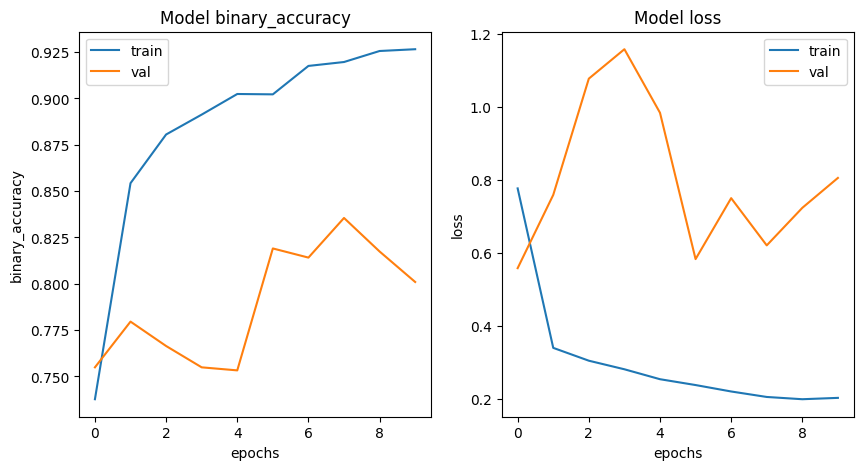

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['binary_accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])

    ax[i].set_title('Model {}'.format(met))

    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)

    ax[i].legend(['train', 'val'])

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['binary_accuracy'][-1])*100, 2)))

20/20 [==============================] - 0s 20ms/step
CONFUSION MATRIX ------------------
[[121 113]
 [  8 382]]

TEST METRICS ----------------------
Accuracy: 80.60897435897436%
Precision: 77.17171717171716%
Recall: 97.94871794871794%
F1-score: 86.3276836158192

TRAIN METRIC ----------------------
Train acc: 92.66


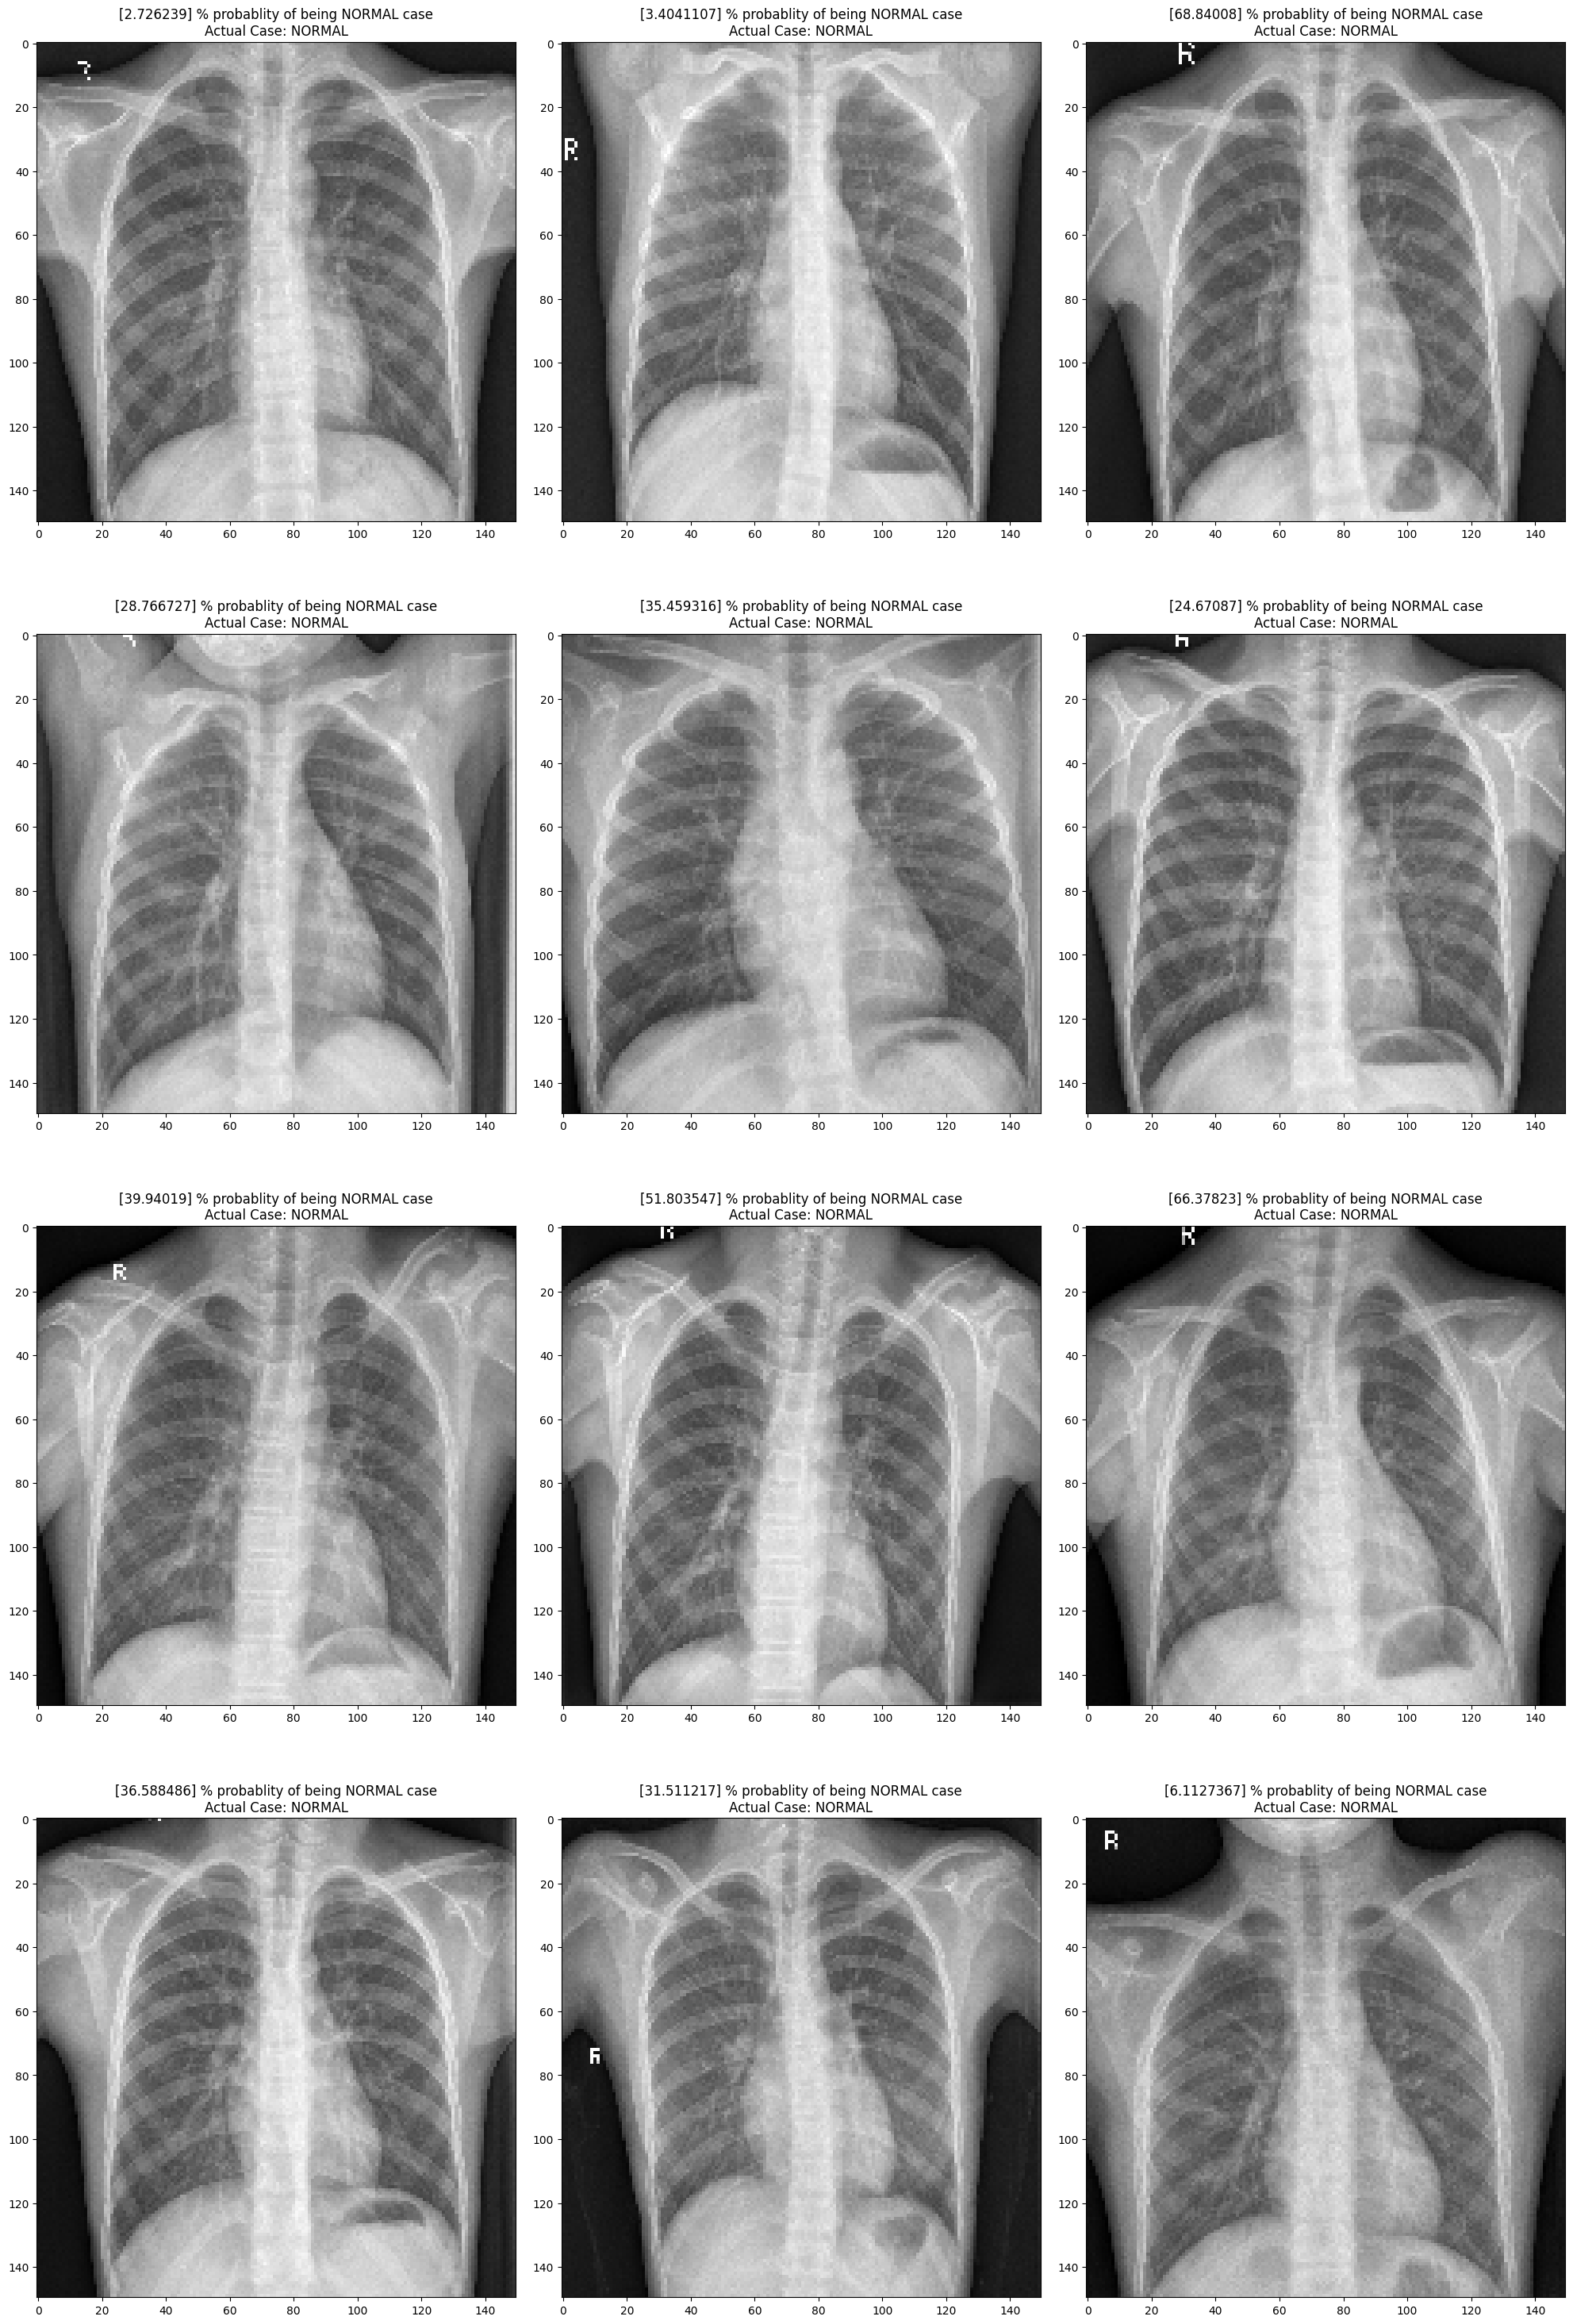

In [32]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')

    if test_labels[i] == 0:
        ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[i]*100) + '\n' + 'Actual Case: PNEUMONIA')

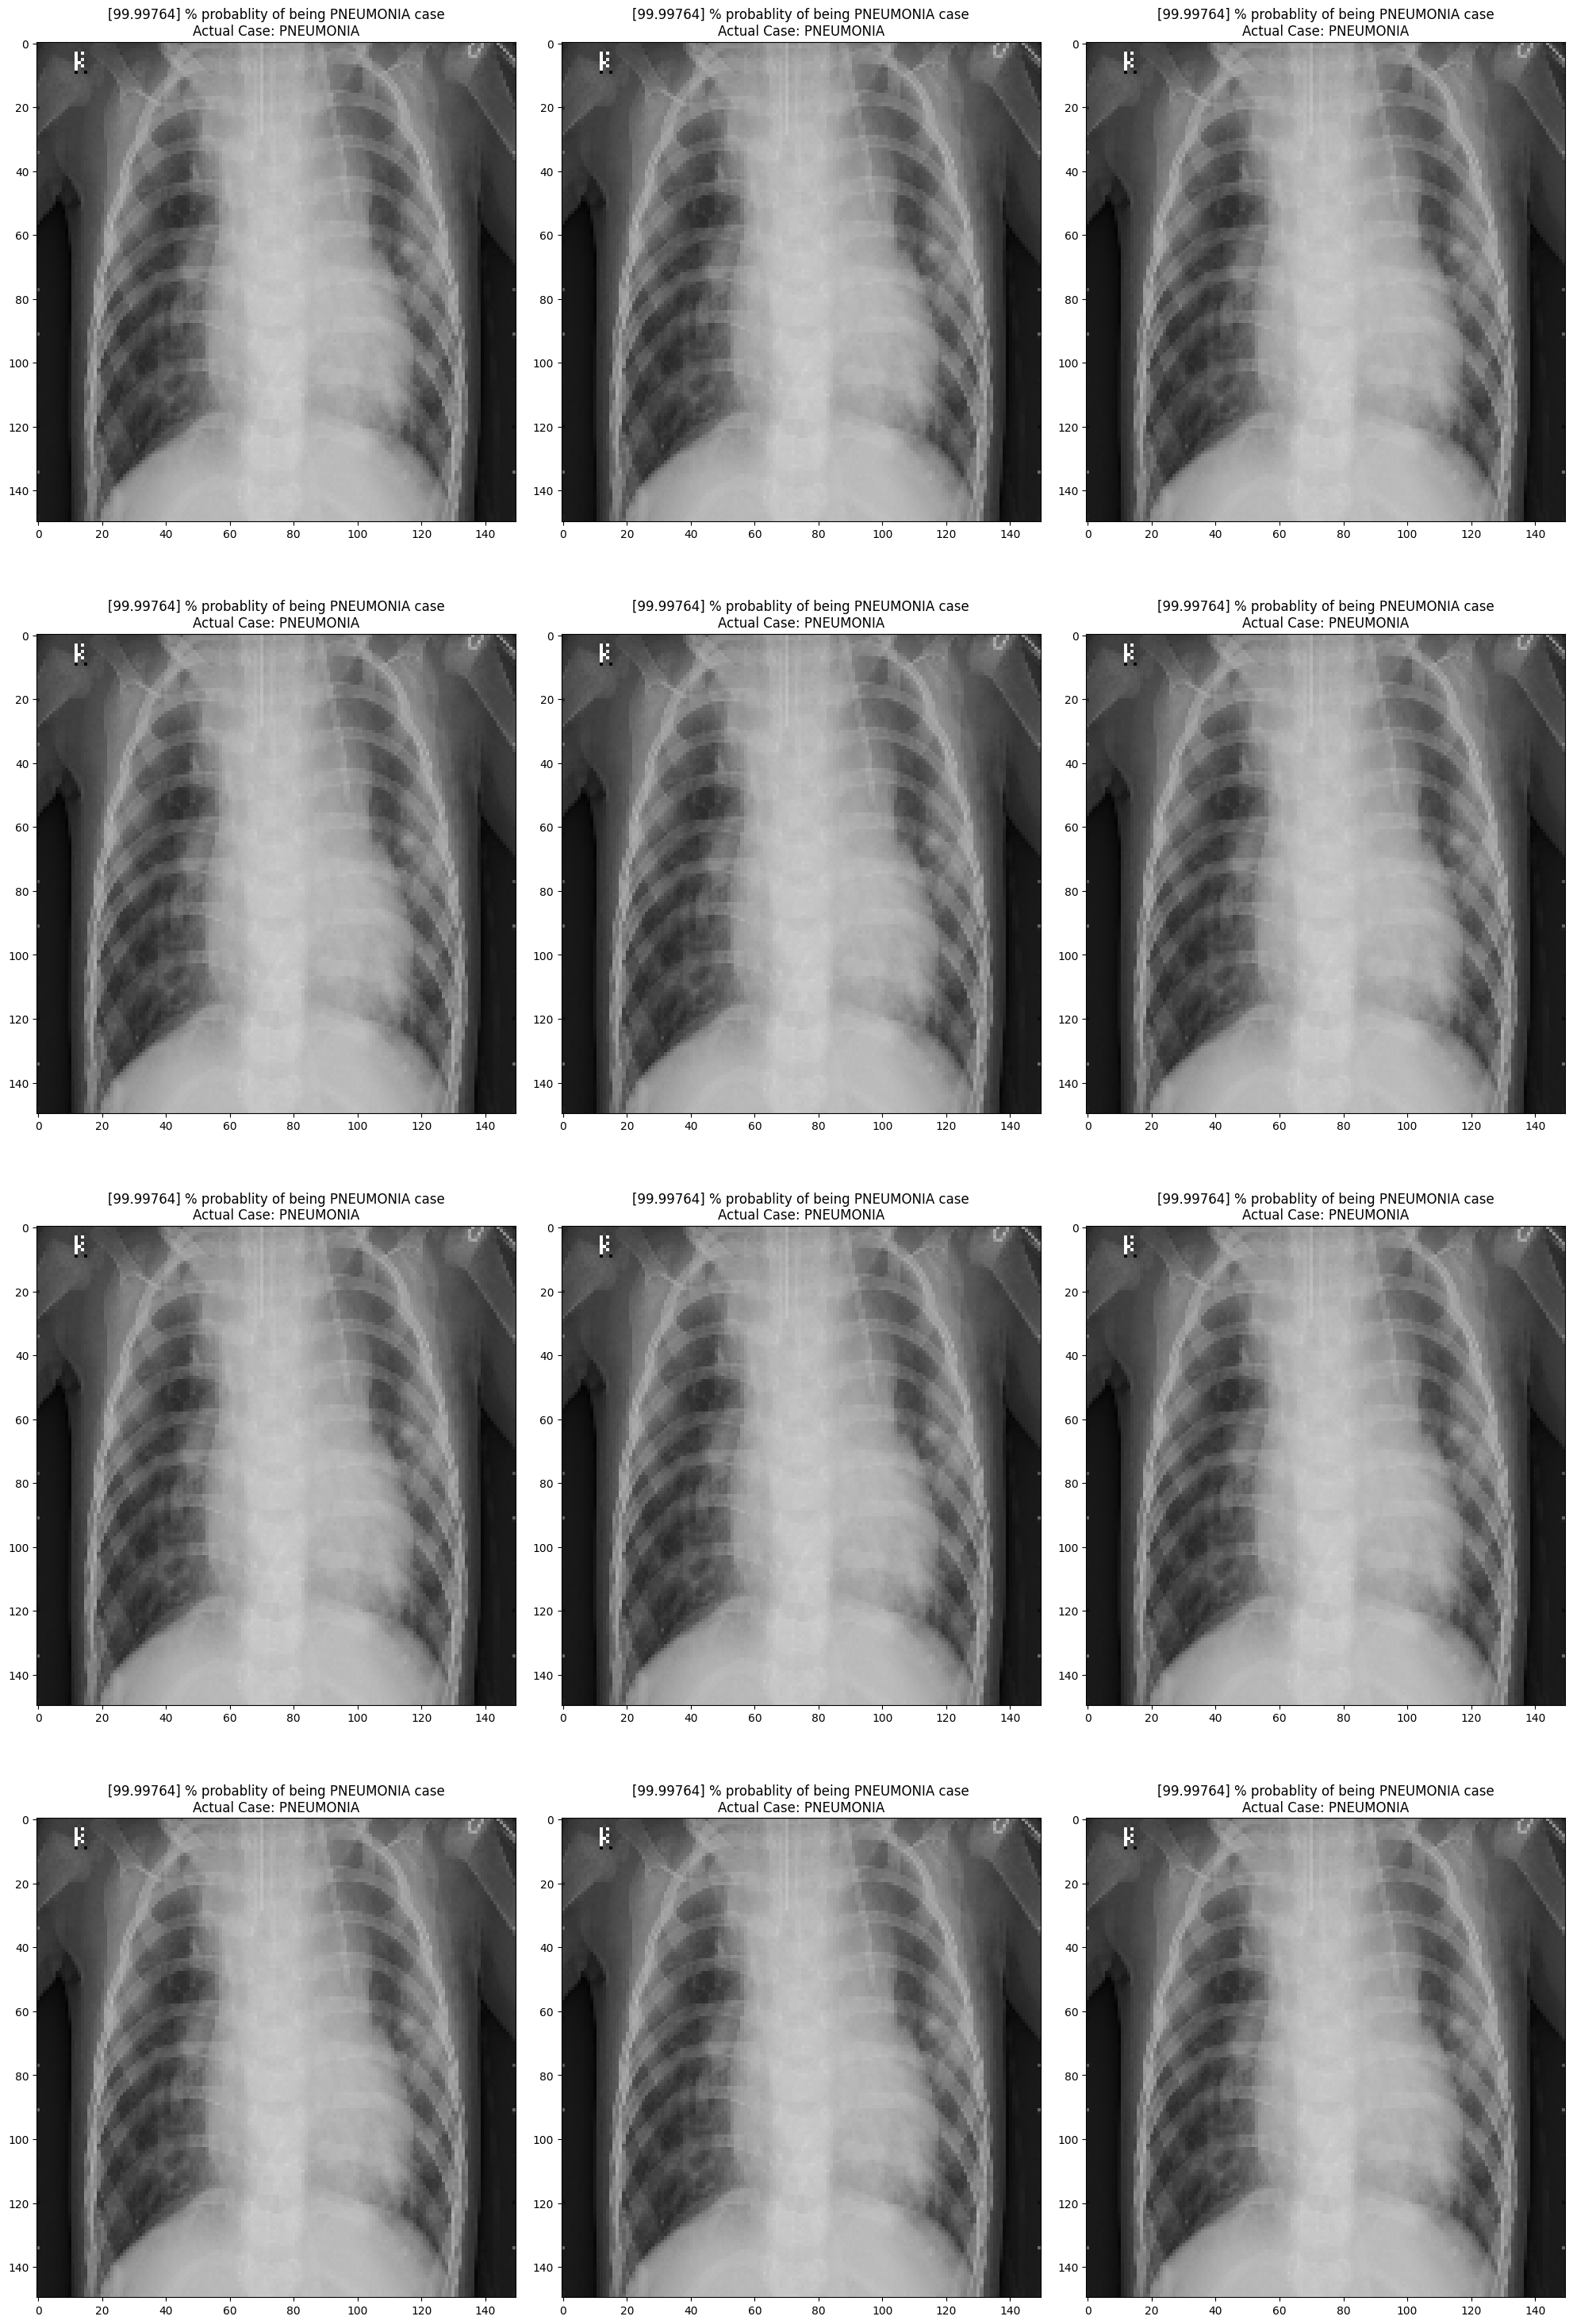

In [33]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    for j in range(234, 246):
        ax[i].imshow(test_data[j])

        if test_labels[j] == 0:
            ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[j])*100) + '\n' + 'Actual Case: NORMAL')
        else:
            ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[j]*100) + '\n' + 'Actual Case: PNEUMONIA')